1. Business Understanding & Data Collection

In [11]:
# data
import yfinance as yf

# mapulating data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as data
import seaborn as sns
import math

In [13]:
# Các hàm hỗ trợ
def moving_average(series: pd.Series, window: int) -> pd.Series:
    return series.rolling(window=window).mean()


def exponential_moving_average(series: pd.Series, span: int) -> pd.Series:
    return series.ewm(span=span, adjust=False).mean()


def obv(df: pd.DataFrame) -> pd.Series:
    direction = np.sign(df["close"].diff()).fillna(0)
    return (direction * df["volume"]).cumsum()


def force_index(df: pd.DataFrame, span: int = 1) -> pd.Series:
    fi = (df["close"] - df["close"].shift(1)) * df["volume"]
    return fi.ewm(span=span, adjust=False).mean() if span > 1 else fi


def vroc(series: pd.Series, window: int = 5) -> pd.Series:
    prev = series.shift(window)
    return (series - prev) / prev.replace(0, np.nan)


def range_and_return(df: pd.DataFrame) -> pd.DataFrame:
    price_range = df["high"] - df["low"]
    daily_return = df["close"].pct_change()
    return pd.DataFrame({"Range": price_range, "Return": daily_return})


def volume_momentum(series: pd.Series, window: int = 5) -> pd.Series:
    return series - series.shift(window)


# Áp dụng các chỉ báo vào DataFrame
def custom_feature_func(df: pd.DataFrame, window: int = 20) -> pd.DataFrame:
    """
    Tạo thêm các feature từ volume, giá và thời gian.
    """
    # 1. Feature giá
    df["date"] = pd.to_datetime(df["date"])
    df["Close_Lag1"] = df["close"].shift(1)
    df["Close_Change"] = df["close"].pct_change()
    df["Close_MA5"] = moving_average(df["close"], 5)

    df["Candle_Body"] = (df["close"] - df["open"]).abs()
    df["Upper_Shadow"] = df["high"] - df[["close", "open"]].max(axis=1)
    df["Lower_Shadow"] = df[["close", "open"]].min(axis=1) - df["low"]

    # 2. Feature volume cơ bản
    df["Volume_MA"] = moving_average(df["volume"], window)
    df["Volume_EMA"] = exponential_moving_average(df["volume"], window)
    df["Volume_STD"] = df["volume"].rolling(window=window).std()
    df["Volume_Momentum"] = volume_momentum(df["volume"], window)
    df["VROC"] = vroc(df["volume"], window=window)

    # 3. Chỉ báo khác từ volume và giá
    df["OBV"] = obv(df)
    df["Force_Index"] = force_index(df, span=window)

    rr = range_and_return(df)
    df["Range"] = rr["Range"]
    df["Return"] = rr["Return"]

    # 4. Feature lag và rolling trên volume
    df["Volume_Lag1"] = df["volume"].shift(1)
    df["Volume_Rolling_Max_30"] = df["volume"].rolling(window=30).max()
    df["Volume_Rolling_Mean_30"] = df["volume"].rolling(window=30).mean()
    df["Volume_Zscore_30"] = (df["volume"] - df["Volume_Rolling_Mean_30"]) / df[
        "volume"
    ].rolling(window=30).std()
    df["Volume_Percentile_30"] = (
        df["volume"]
        .rolling(window=30)
        .apply(lambda x: pd.Series(x).rank(pct=True).iloc[-1], raw=False)
    )  # 5. Feature thời gian
    df["Day_of_Week"] = df["date"].dt.dayofweek
    df["Is_Month_End"] = df["date"].dt.is_month_end.astype(int)
    df["Is_Month_Start"] = df["date"].dt.is_month_start.astype(int)

    return df


def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    - Gọi custom_feature_func để tạo toàn bộ feature.
    - Loại bỏ cột giá gốc, giữ lại date, volume và các feature mới.
    - Xóa NaN và sắp xếp theo date.
    """
    df = df.copy()
    df = custom_feature_func(df)
    df.drop(["open", "high", "low", "close"], axis=1, inplace=True, errors="ignore")
    df.dropna(inplace=True)
    df = df.sort_values(by="date", ascending=True).reset_index(drop=True)
    return df

In [14]:
# boxplot
def boxplot_features(df):
    n_cols = df.shape[1]
    n_rows = math.ceil(n_cols / 5)

    fig, axes = plt.subplots(n_rows, 5, figsize=(12, 5 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(df.columns):
        sns.boxplot(y=df[col], ax=axes[i])
        axes[i].set_title(col)
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


# Histogram
def hist_features(df):
    n_cols = df.shape[1]
    n_rows = math.ceil(n_cols / 5)

    fig, axes = plt.subplots(n_rows, 5, figsize=(12, 5 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(df.columns):
        sns.histplot(df[col], ax=axes[i])
        axes[i].set_title(col)
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


# Line chart


def line_features(df):
    df = df.sort_values("date")
    n_cols = df.shape[1] - 1
    n_rows = math.ceil(n_cols / 5)

    fig, axes = plt.subplots(n_rows, 5, figsize=(25, 5 * n_rows))
    axes = axes.flatten()

    feature_cols = [col for col in df.columns if col != "date"]

    for i, col in enumerate(feature_cols):
        axes[i].plot(df["date"], df[col])
        axes[i].set_title(col)
        axes[i].tick_params(axis="x", rotation=45)

    # Ẩn subplot thừa
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

In [15]:
df = yf.download("GC=F", start="2015-1-2", end="2025-5-25")

df = df.reset_index()
df.columns = ["date", "close", "high", "low", "open", "volume"]
df = df.sort_values(by="date", ascending=True)

[*********************100%***********************]  1 of 1 completed


#Data Description & Preprocessing

In [16]:
# df trước xử lý
display(df.head())
df.info()

,date,close,high,low,open,volume
0,2015-01-02,1186.000000,1194.500000,1169.500000,1184.000000,138
1,2015-01-05,1203.900024,1206.900024,1180.099976,1180.300049,470
2,2015-01-06,1219.300049,1220.000000,1203.500000,1203.500000,97
3,2015-01-07,1210.599976,1219.199951,1210.599976,1219.199951,29
4,2015-01-08,1208.400024,1215.699951,1206.300049,1207.000000,92


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2612 entries, 0 to 2611
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2612 non-null   datetime64[ns]
 1   close   2612 non-null   float64       
 2   high    2612 non-null   float64       
 3   low     2612 non-null   float64       
 4   open    2612 non-null   float64       
 5   volume  2612 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 122.6 KB


In [17]:
round(df.drop(columns=["date"], axis=1).describe(), 3)

,close,high,low,open,volume
count,2612.000,2612.000,2612.000,2612.000,2612.000
mean,1656.773,1664.752,1648.642,1656.549,5207.614
std,471.917,475.167,468.262,471.538,28750.732
min,1050.800,1062.000,1046.200,1053.700,0.000
25%,1266.575,1271.575,1260.950,1266.975,49.000
50%,1627.000,1639.450,1617.200,1623.600,187.000
75%,1901.325,1910.050,1892.550,1901.300,580.000
max,3411.400,3485.600,3364.700,3422.200,386334.000


In [18]:
# df sau khi xử lý
df_model = preprocess_data(df)
display(df_model.info())
df_model.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2552 entries, 0 to 2551
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    2552 non-null   datetime64[ns]
 1   volume                  2552 non-null   int64         
 2   Close_Lag1              2552 non-null   float64       
 3   Close_Change            2552 non-null   float64       
 4   Close_MA5               2552 non-null   float64       
 5   Candle_Body             2552 non-null   float64       
 6   Upper_Shadow            2552 non-null   float64       
 7   Lower_Shadow            2552 non-null   float64       
 8   Volume_MA               2552 non-null   float64       
 9   Volume_EMA              2552 non-null   float64       
 10  Volume_STD              2552 non-null   float64       
 11  Volume_Momentum         2552 non-null   float64       
 12  VROC                    2552 non-null   float64 

None

,date,volume,Close_Lag1,Close_Change,Close_MA5,Candle_Body,Upper_Shadow,Lower_Shadow,Volume_MA,Volume_EMA,...,Range,Return,Volume_Lag1,Volume_Rolling_Max_30,Volume_Rolling_Mean_30,Volume_Zscore_30,Volume_Percentile_30,Day_of_Week,Is_Month_End,Is_Month_Start
0,2015-02-13,65,1220.099976,0.005245,1227.600000,4.300049,6.300049,0.000000,13177.90,7936.872886,...,10.600098,0.005245,99.0,180387.0,8823.266667,-0.252432,0.300000,4,0,0
1,2015-02-17,204,1226.500000,-0.015002,1221.059985,19.599976,6.300049,5.099976,13185.90,7200.408801,...,31.000000,-0.015002,65.0,180387.0,8825.466667,-0.248493,0.666667,1,0,0
2,2015-02-18,147,1208.099976,-0.006953,1214.679980,7.400024,3.099976,1.899902,13185.40,6528.655582,...,12.399902,-0.006953,204.0,180387.0,8814.700000,-0.249806,0.633333,2,0,0
3,2015-02-19,65,1199.699951,0.006168,1212.299976,9.400024,3.500000,2.099976,13184.75,5913.069336,...,15.000000,0.006168,147.0,180387.0,8813.633333,-0.252137,0.316667,3,0,0
4,2015-02-20,51,1207.099976,-0.002237,1209.159985,2.099976,6.599976,5.300049,13180.75,5354.777019,...,14.000000,-0.002237,65.0,180387.0,8814.366667,-0.252563,0.266667,4,0,0


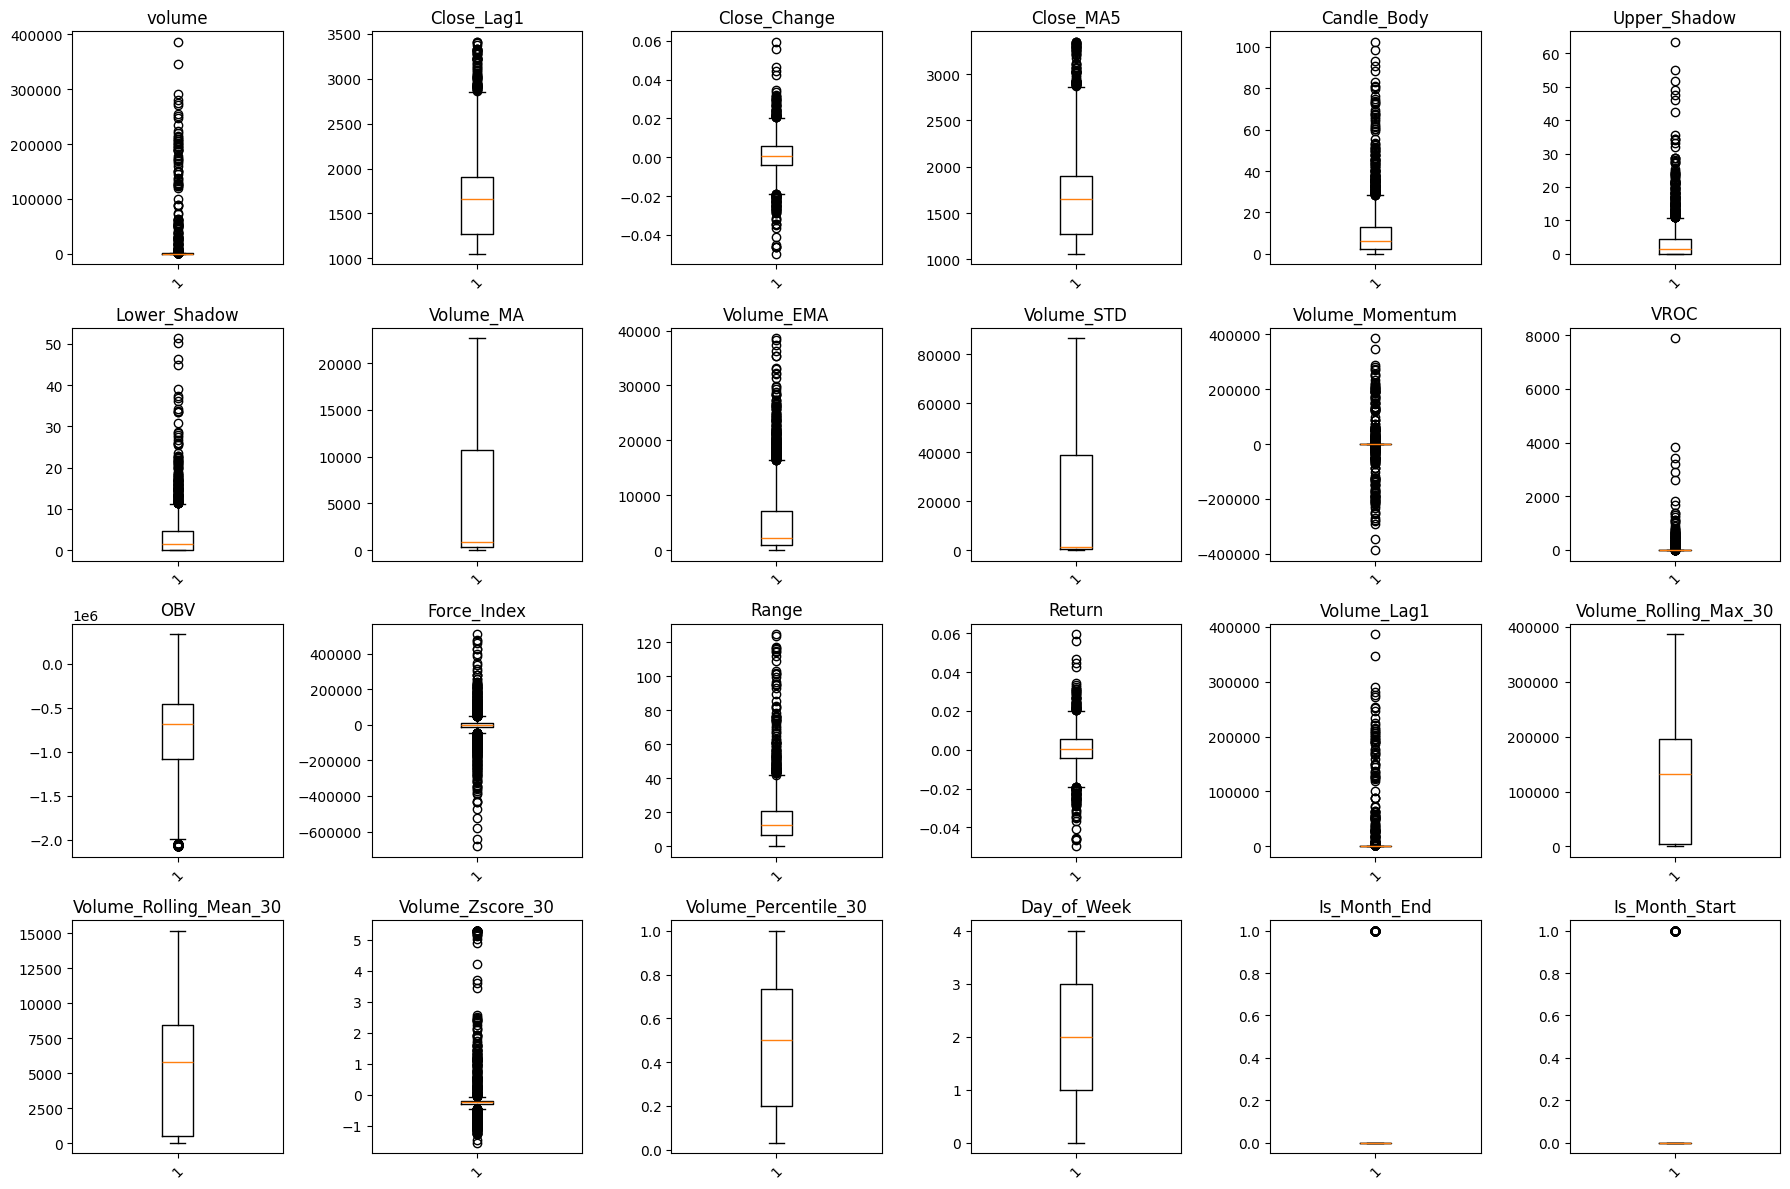

In [19]:
# Boxplot
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(18, 12))
axes = axes.flatten()

for i in range(24):
    axes[i].boxplot(df_model.drop(["date"], axis=1).iloc[:, i].dropna())
    axes[i].set_title(df_model.drop(["date"], axis=1).columns[i])
    axes[i].tick_params(axis="x", labelrotation=45)

plt.tight_layout()
plt.show()

3. Data Analysis

In [20]:
# Thống kê mô tả
def describe_data(df):
    print("== Thông tin DataFrame ==")
    print(df.info())
    print("\n== Thống kê mô tả ==")
    display(df.describe().style.background_gradient(cmap="Blues"))
    print("\n== Số lượng giá trị bị thiếu ==")
    print(df.isnull().sum())


describe_data(df)

== Thông tin DataFrame ==
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2612 entries, 0 to 2611
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2612 non-null   datetime64[ns]
 1   close   2612 non-null   float64       
 2   high    2612 non-null   float64       
 3   low     2612 non-null   float64       
 4   open    2612 non-null   float64       
 5   volume  2612 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 122.6 KB
None

== Thống kê mô tả ==


,date,close,high,low,open,volume
count,2612,2612.000000,2612.000000,2612.000000,2612.000000,2612.000000
mean,2020-03-13 22:56:36.018376448,1656.772510,1664.751609,1648.642075,1656.549004,5207.614472
min,2015-01-02 00:00:00,1050.800049,1062.000000,1046.199951,1053.699951,0.000000
25%,2017-08-08 18:00:00,1266.574982,1271.574982,1260.950012,1266.975006,49.000000
50%,2020-03-16 12:00:00,1627.000000,1639.450012,1617.200012,1623.600037,187.000000
75%,2022-10-17 06:00:00,1901.325043,1910.049988,1892.549988,1901.300049,580.000000
max,2025-05-23 00:00:00,3411.399902,3485.600098,3364.699951,3422.199951,386334.000000
std,nan,471.917184,475.167458,468.261891,471.537788,28750.732191



== Số lượng giá trị bị thiếu ==
date      0
close     0
high      0
low       0
open      0
volume    0
dtype: int64


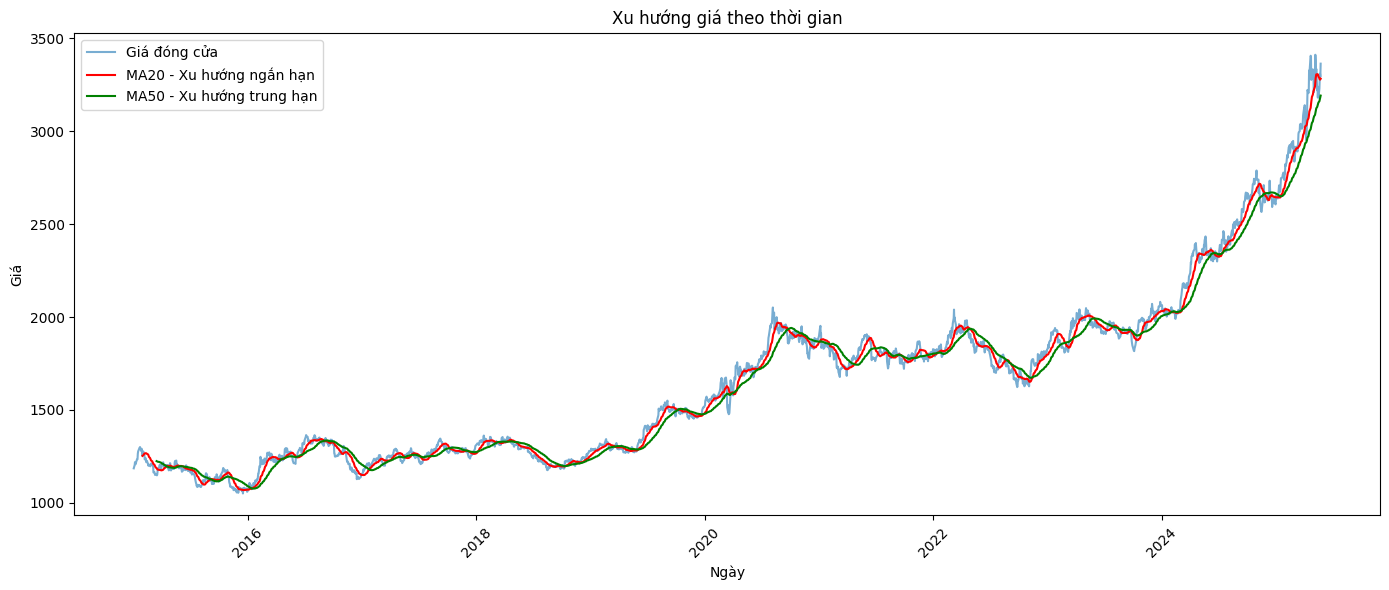

In [21]:
# trend bằng đường trung bình động (Moving Average)
plt.figure(figsize=(14, 6))
plt.plot(df["date"], df["close"], label="Giá đóng cửa", alpha=0.6)
plt.plot(
    df["date"],
    df["close"].rolling(window=20).mean(),
    label="MA20 - Xu hướng ngắn hạn",
    color="red",
)
plt.plot(
    df["date"],
    df["close"].rolling(window=50).mean(),
    label="MA50 - Xu hướng trung hạn",
    color="green",
)
plt.title("Xu hướng giá theo thời gian")
plt.xlabel("Ngày")
plt.ylabel("Giá")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

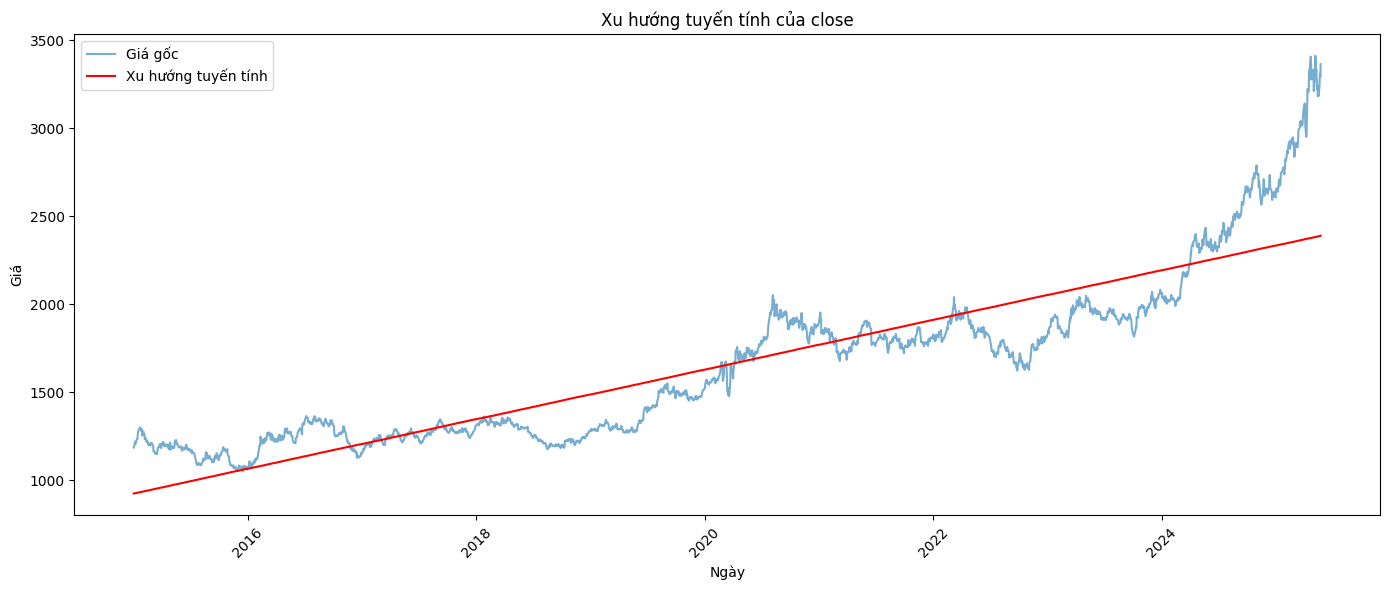

In [ ]:
from sklearn.linear_model import LinearRegression


# Trend bằng hồi quy tuyến tính
def plot_linear_trend(df, column="close"):
    df = df.copy().dropna(subset=[column])
    df = df.reset_index(drop=True)

    X = np.arange(len(df)).reshape(-1, 1)
    y = df[column].values
    model = LinearRegression().fit(X, y)
    df["Linear_Trend"] = model.predict(X)

    plt.figure(figsize=(14, 6))
    plt.plot(df["date"], df[column], label="Giá gốc", alpha=0.6)
    plt.plot(df["date"], df["Linear_Trend"], label="Xu hướng tuyến tính", color="red")
    plt.title(f"Xu hướng tuyến tính của {column}")
    plt.xlabel("Ngày")
    plt.ylabel("Giá")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


plot_linear_trend(df, "close")

4. Data Visualization

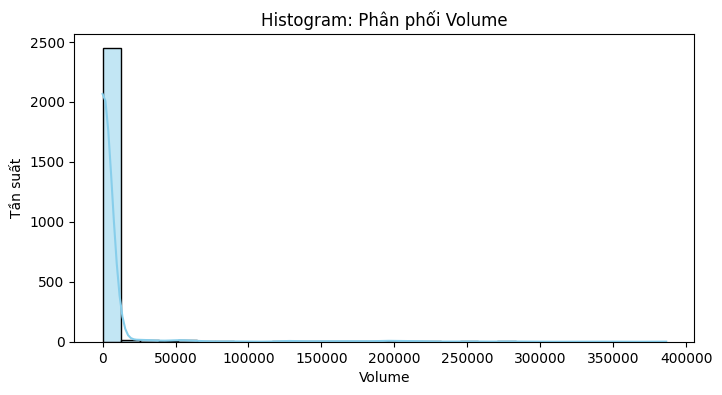

In [ ]:
# 1. Histogram - Phân phối volume
plt.figure(figsize=(8, 4))
sns.histplot(df_model["volume"], bins=30, kde=True, color="skyblue")
plt.title("Histogram: Phân phối Volume")
plt.xlabel("Volume")
plt.ylabel("Tần suất")
plt.show()

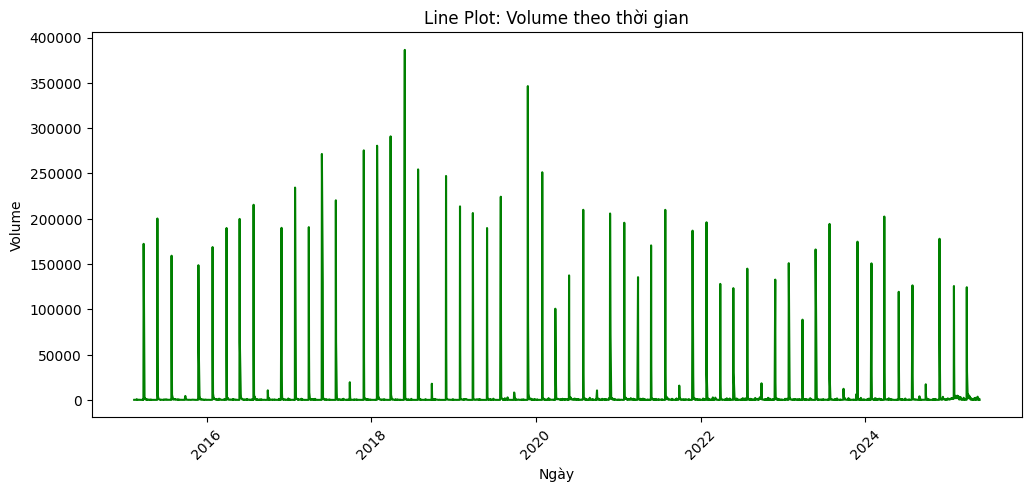

In [25]:
# 2. Line Plot - Biểu đồ Volume theo thời gian
plt.figure(figsize=(12, 5))
plt.plot(df_model["date"], df_model["volume"], color="green")
plt.title("Line Plot: Volume theo thời gian")
plt.xlabel("Ngày")
plt.ylabel("Volume")
plt.xticks(rotation=45)
plt.show()

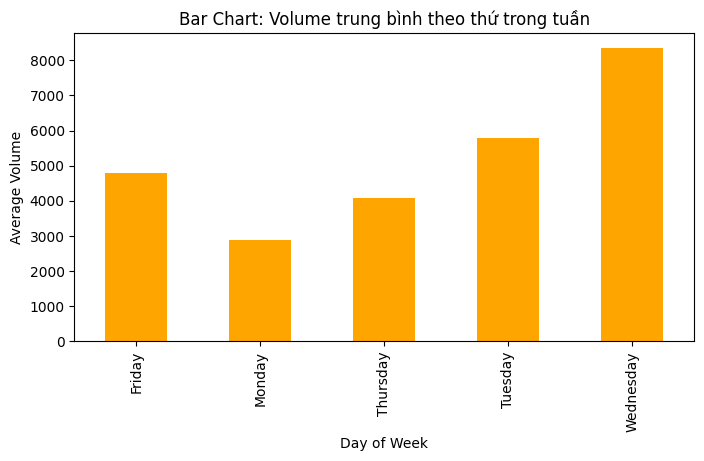

In [26]:
# 3. Bar Chart - Trung bình volume theo ngày trong tuần
day_names = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday",
]
df_model["Day_of_Week_Label"] = df_model["Day_of_Week"].map(dict(enumerate(day_names)))
avg_volume = df_model.groupby("Day_of_Week_Label")["volume"].mean()

plt.figure(figsize=(8, 4))
avg_volume.plot(kind="bar", color="orange")
plt.title("Bar Chart: Volume trung bình theo thứ trong tuần")
plt.xlabel("Day of Week")
plt.ylabel("Average Volume")
plt.show()

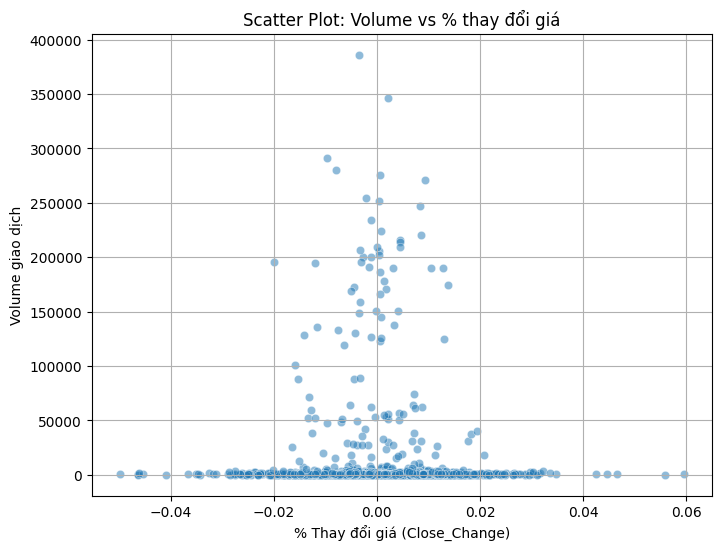

In [27]:
# 4. Scatter Plot - Volume vs % thay đổi giá
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_model, x="Close_Change", y="volume", alpha=0.5)
plt.title("Scatter Plot: Volume vs % thay đổi giá")
plt.xlabel("% Thay đổi giá (Close_Change)")
plt.ylabel("Volume giao dịch")
plt.grid(True)
plt.show()

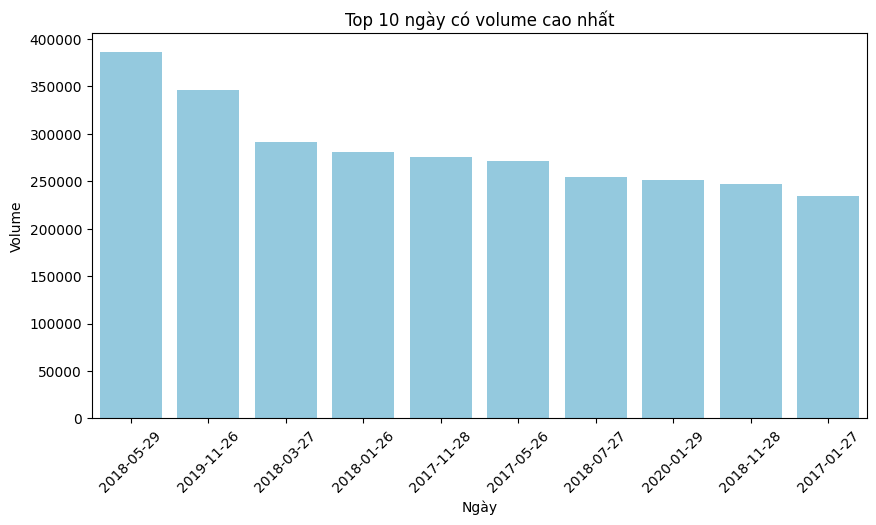

In [28]:
# 5. Bar Chart: Top 10 ngày có volume cao nhất
top10 = df_model.sort_values("volume", ascending=False).head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top10["date"].dt.strftime("%Y-%m-%d"), y=top10["volume"], color="skyblue")
plt.title("Top 10 ngày có volume cao nhất")
plt.xlabel("Ngày")
plt.ylabel("Volume")
plt.xticks(rotation=45)
plt.show()

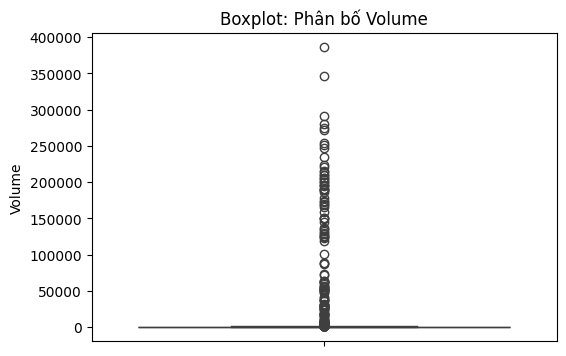

In [29]:
# 6. Boxplot - Phân bố volume
plt.figure(figsize=(6, 4))
sns.boxplot(y=df_model["volume"])
plt.title("Boxplot: Phân bố Volume")
plt.ylabel("Volume")
plt.show()

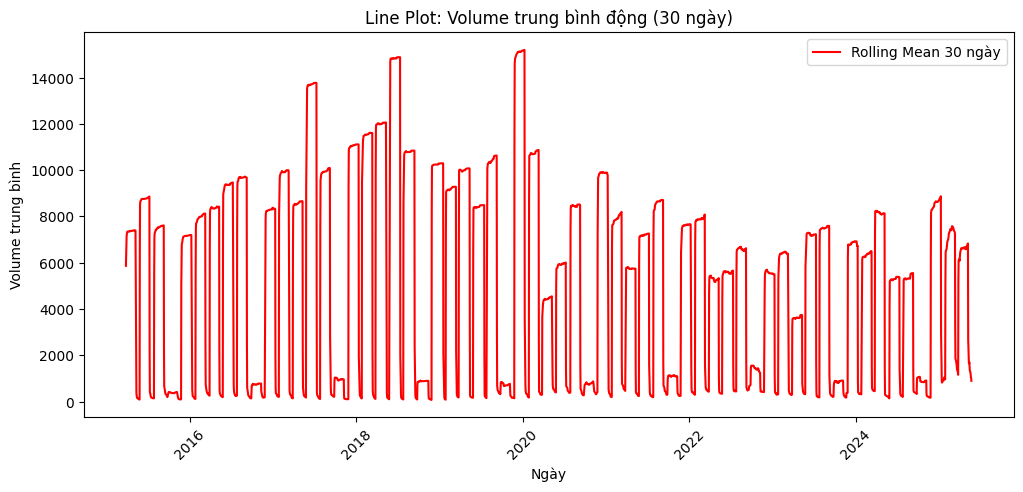

In [30]:
# 7. Line Plot: Volume Rolling Mean (30 ngày)
plt.figure(figsize=(12, 5))
plt.plot(
    df_model["date"],
    df_model["volume"].rolling(30).mean(),
    label="Rolling Mean 30 ngày",
    color="red",
)
plt.title("Line Plot: Volume trung bình động (30 ngày)")
plt.xlabel("Ngày")
plt.ylabel("Volume trung bình")
plt.xticks(rotation=45)
plt.legend()
plt.show()

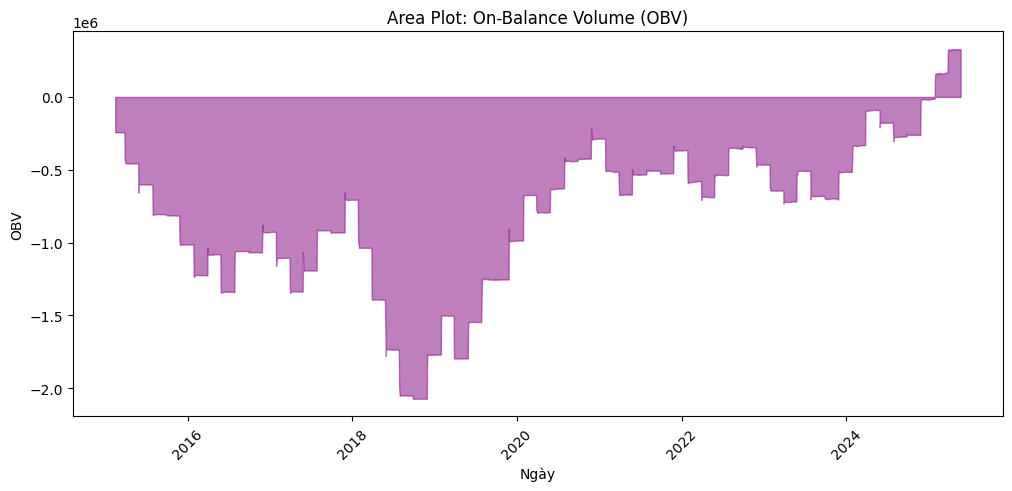

In [31]:
# 8. Area Plot: Lượng giao dịch tích lũy (OBV)
plt.figure(figsize=(12, 5))
plt.fill_between(df_model["date"], df_model["OBV"], color="purple", alpha=0.5)
plt.title("Area Plot: On-Balance Volume (OBV)")
plt.xlabel("Ngày")
plt.ylabel("OBV")
plt.xticks(rotation=45)
plt.show()

Model for Prediction

In [ ]:
# model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (
    mean_squared_error,
    classification_report,
    mean_absolute_percentage_error,
    mean_absolute_error,
    r2_score,
)

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

from xgboost import XGBRegressor

In [ ]:
# Preprocess Data
X = df_model.drop(["date", "volume"], axis=1)
y = df_model["volume"]

# split train test using  Time Series Cross-Validator
tscv = TimeSeriesSplit(n_splits=5)
split = list(tscv.split(X))
train_index, test_index = split[-1]
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# robust scale
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
linearR = LinearRegression()
linearR.fit(X_train, y_train)
y_pred = linearR.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("R2:", r2)

In [ ]:
knn = KNeighborsRegressor(n_neighbors=3, p=1, weights="distance")
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("R2:", r2)

In [ ]:
randForest = RandomForestRegressor(
    max_depth=20,
    max_features=0.8,
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=100,
    random_state=42,
)
randForest.fit(X_train, y_train)
y_pred = randForest.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("R2:", r2)

In [ ]:
polyR = make_pipeline(PolynomialFeatures(3), LinearRegression())
polyR.fit(X_train, y_train)
y_pred = polyR.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("mae:", mae)
print("rmse:", rmse)
print("r2:", r2)

In [ ]:
xgb = XGBRegressor(
    colsample_bytree=1,
    learning_rate=0.1,
    max_depth=7,
    n_estimators=200,
    subsample=1,
    random_state=42,
)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("mae:", mae)
print("rmse:", rmse)
print("r2:", r2)